# Сборный проект-5

### Описание проекта

Мы работаем в фотохостинге для профессиональных фотографов «Со Смыслом» (“With Sense”). 
Наши пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т.д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала. 

Чтобы эксперимент получил право на жизнь, нужно защитить его перед руководителем компании. Для защиты необходимо презентовать так называемый PoC (Proof of Concept, Проверка концепции) — продемонстрировать, что такой проект практически осуществим. 

Нам поручено разработать демонстрационную версию поиска изображений по запросу.
Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу. 
На основе лучшей модели можно будет собрать предварительную версию продукта, которую вы покажете руководителю компании.

### Цель проекта
Разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Юридические ограничения

В некоторых странах, где работает компания With Sense, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет.
В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:
⎢ This image is unavailable in your country in compliance with local laws.
Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому необходимо очистить данные от проблемного контента. Во время тестирования модели при появлении в запросе “вредного” контента должен отображаться дисклеймер. 

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
#pip install ipywidgets

In [2]:
# Загружаем необходимые бибдиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import matplotlib.image as mpimg
import seaborn as sns
from pathlib import Path
import os
import re
from random import sample
import torch
import transformers
from tqdm import notebook
from math import sqrt

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit


from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor


from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout


from wordcloud import WordCloud
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zurik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zurik\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\zurik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# Определяем константы
path1 = '/Users/zurik/YandexDisk/Yandex Practicum/Data Science/project-5/dsplus_integrated_project_4/to_upload'
path2 = '/Users/User/YandexDisk/Yandex Practicum/Data Science/project-5/dsplus_integrated_project_4/to_upload'

PATH = path1 if os.path.exists(path1) else path2

train_image_dir = Path(PATH) / 'train_images'
test_image_dir = Path(PATH) / 'test_images'

RANDOM_STATE = 42
TEST_SIZE = 0.25

# Создадим список блокируемых слов, связанных с детьми
STOP_WORDS = {
    'teen', 'teens', 'teenage', 'teenager', 'teenagers',
    'baby', 'babies', 
    'child', 'children', 'kid', 'kids',
    'girl', 'girls', 'boy', 'boys',
    'youngster', 'youngsters', 'youth', 'youths',
    'young', 'babe', 'babes'}

## 1. Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [4]:
# Загрузка и изучение данных
df_train = pd.read_csv(Path(PATH, 'train_dataset.csv'))

df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [5]:
df_crowd = pd.read_csv(Path(PATH, 'CrowdAnnotations.tsv'), sep = '\t', names= ['image', 'descr_id', 'ratio_confirmed', 'num_confirmed', 'num_rejected'])

df_crowd.info()
df_crowd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   descr_id         47830 non-null  object 
 2   ratio_confirmed  47830 non-null  float64
 3   num_confirmed    47830 non-null  int64  
 4   num_rejected     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


image                     descr_id  ratio_confirmed  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

   num_confirmed  num_rejected  
0              3             0  
1              0             3  
2              0             3  
3              0             3  
4              0             3

In [6]:
df_expert = pd.read_csv(Path(PATH, 'ExpertAnnotations.tsv'), sep = '\t', names= ['image', 'descr_id', 'first', 'second', 'third'])

df_expert.info()
df_expert.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   descr_id  5822 non-null   object
 2   first     5822 non-null   int64 
 3   second    5822 non-null   int64 
 4   third     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


image                     descr_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  
0      1  
1      2  
2      2  
3      2  
4      2

In [7]:
df_test = pd.read_csv(Path(PATH, 'test_queries.csv'), index_col=[0], sep='|')

df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [8]:
df_images = pd.read_csv(Path(PATH, 'test_images.csv'), sep='|')

df_images.info()
df_images.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

 - Данные успешно загружены
 - Пропуски не обнаружены
 - Детальнее изучим датафреймы

#### Анализ уникальных значений df_train

Уникальных фотографий: 1000
Уникальных query_id: 977
Уникальных описаний (query_text): 977


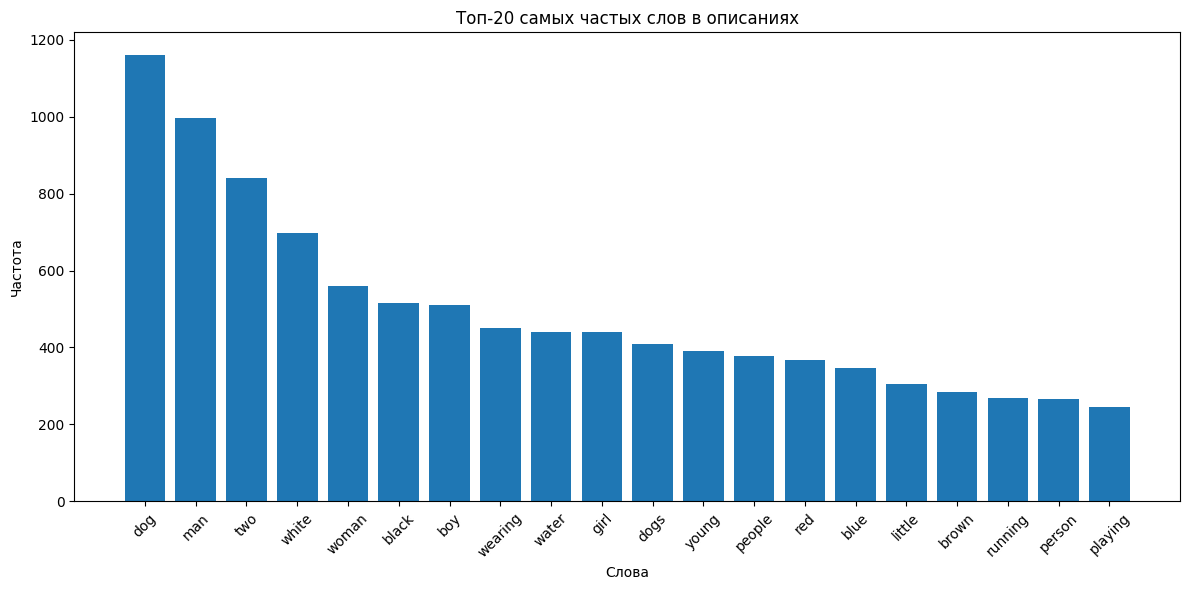

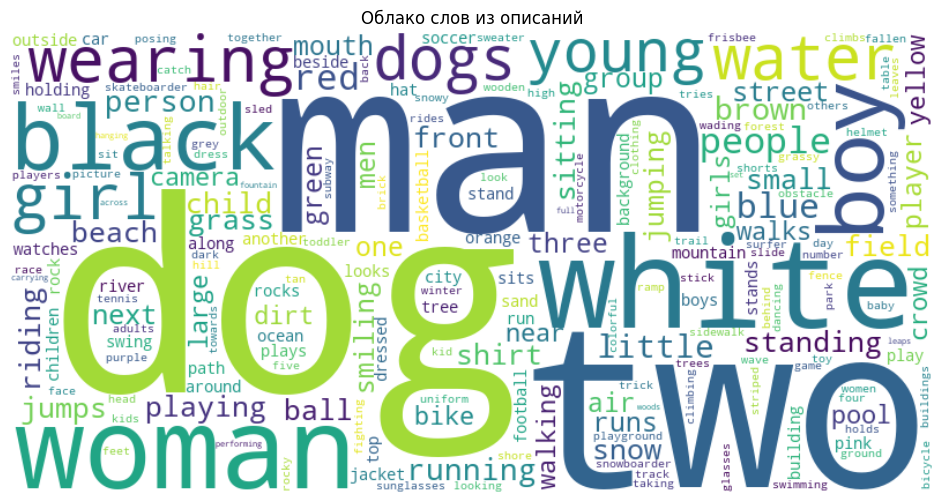

In [9]:
# 1. Анализ уникальных значений df_train
print("Уникальных фотографий:", df_train['image'].nunique())
print("Уникальных query_id:", df_train['query_id'].nunique())
print("Уникальных описаний (query_text):", df_train['query_text'].nunique())

# 2. Анализ самых частых слов в описаниях
# Собираем все тексты в одну строку
all_text = ' '.join(df_train['query_text'].astype(str).str.lower())

# Токенизация и очистка от стоп-слов
tokens = word_tokenize(all_text)
stop_words = set(stopwords.words('english'))  # стоп-слова для английского языка
filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

# Подсчет частоты слов
word_freq = Counter(filtered_tokens)
top_words = word_freq.most_common(20)  # Топ-20 слов

# Создаем DataFrame для визуализации
top_words_df = pd.DataFrame(top_words, columns=['Word', 'Frequency'])

# Визуализация 1: Столбчатая диаграмма
plt.figure(figsize=(12, 6))
plt.bar(top_words_df['Word'], top_words_df['Frequency'])
plt.title('Топ-20 самых частых слов в описаниях')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Визуализация 2: Облако слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов из описаний')
plt.show()

 - Уникальных фотографий 1000
 - Уникальных описаний 977
 - Самые популярные слова: dog, man, two, white, woman

#### Распределение описаний в df_crowd

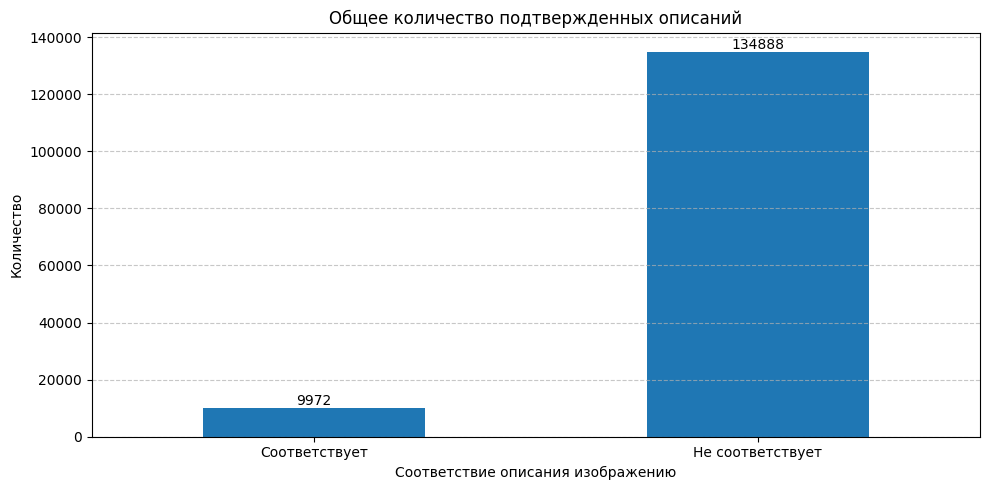

In [10]:
# Распределение подтвержденных/отклоненных описаний краудсорсинаг в df_crowd
plt.figure(figsize=(10, 5))
ax = df_crowd[['num_confirmed', 'num_rejected']].sum().plot(kind='bar')

# Устанавливаем правильные названия для столбцов
ax.set_xticklabels(['Соответствует', 'Не соответствует'], rotation=0)

plt.title('Общее количество подтвержденных описаний')
plt.ylabel('Количество')
plt.xlabel('Соответствие описания изображению')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавляем значения поверх столбцов
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 5), 
                textcoords='offset points')

plt.tight_layout()
plt.show()

 - В данных по соответствию изображения и описания, полученные с помощью краудсорсинга виден существенный дисбаланс подтвердивших, что описание не соответствует

#### Распределение оценок

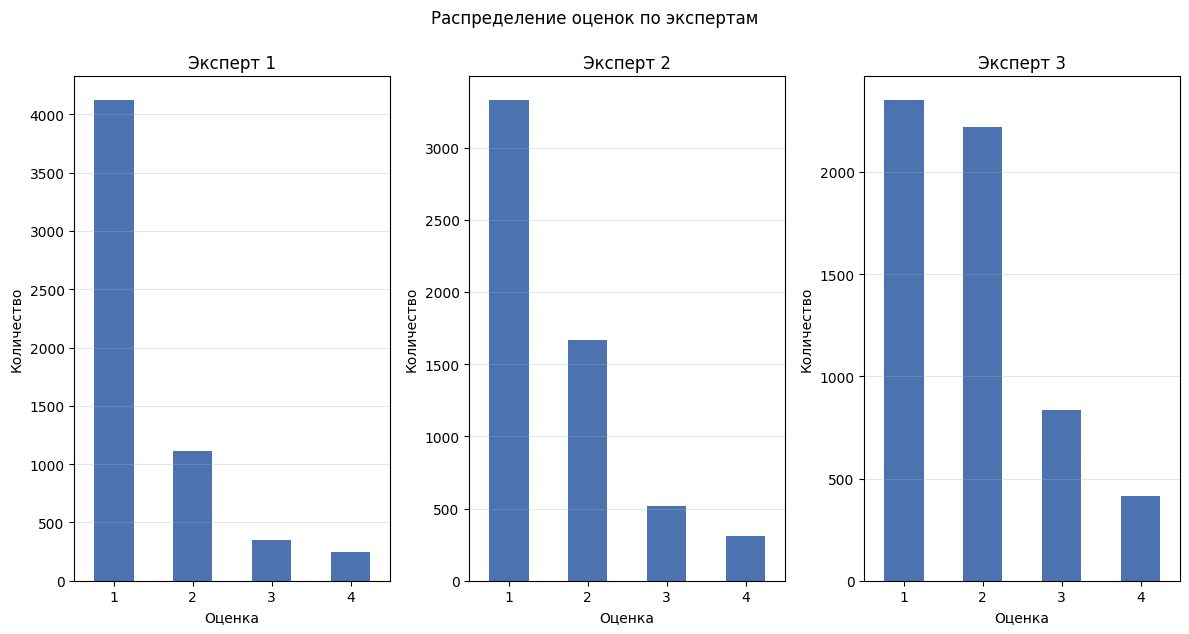

In [11]:
# Посмортим на распределение оценок по экспертам в df_expert
plt.figure(figsize=(12, 6))
for i, col in enumerate(['first', 'second', 'third'], 1):
    plt.subplot(1, 3, i)
    df_expert[col].value_counts().sort_index().plot(kind='bar', color='#4C72B0')
    plt.title(f'Эксперт {i}')
    plt.xlabel('Оценка')
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.suptitle('Распределение оценок по экспертам', y=1.05)
plt.show()

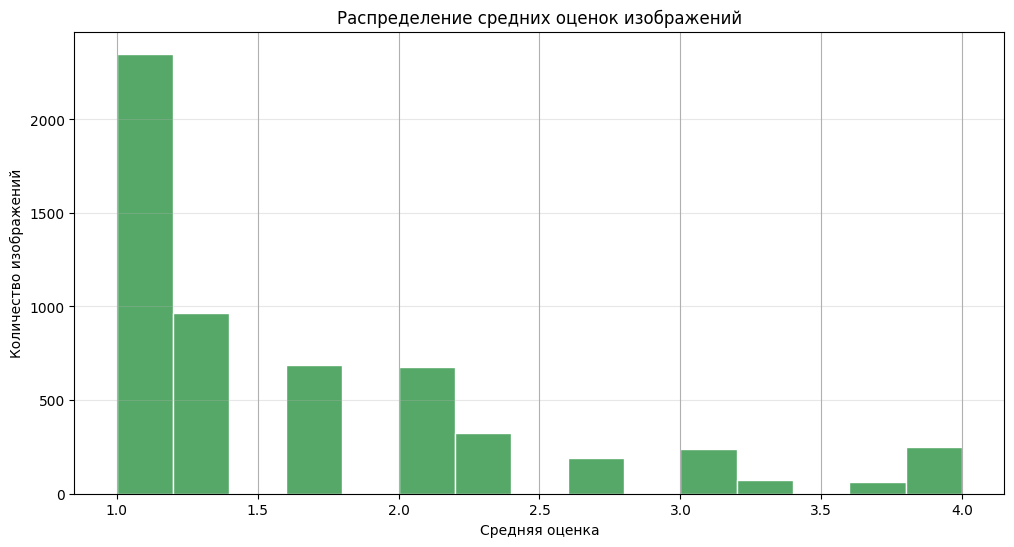

In [12]:
df_expert['mean_score'] = df_expert[['first', 'second', 'third']].mean(axis=1)

plt.figure(figsize=(12, 6))
df_expert['mean_score'].hist(bins=15, color='#55A868', edgecolor='white')
plt.title('Распределение средних оценок изображений')
plt.xlabel('Средняя оценка')
plt.ylabel('Количество изображений')
plt.grid(axis='y', alpha=0.3)
plt.show()

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью

 - Мы видим, что оценки экпертов похожи н оценки краудсорсинга. Большинство оценок говорит о том, что изображение и запрос не соответствуют друг другу.

#### Сравнение фото и текста в df_train и df_test

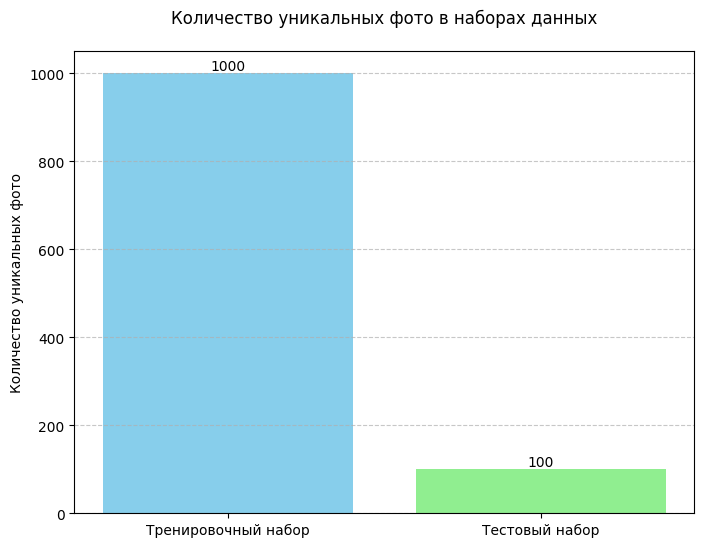

In [13]:

unique_counts = {
    'Тренировочный набор': len(df_train['image'].unique()),
    'Тестовый набор': len(df_test['image'].unique())
}

# Создание графика
plt.figure(figsize=(8, 6))
bars = plt.bar(unique_counts.keys(), unique_counts.values(), color=['skyblue', 'lightgreen'])

# Добавление значений на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

# Настройки графика
plt.title('Количество уникальных фото в наборах данных', pad=20)
plt.ylabel('Количество уникальных фото')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

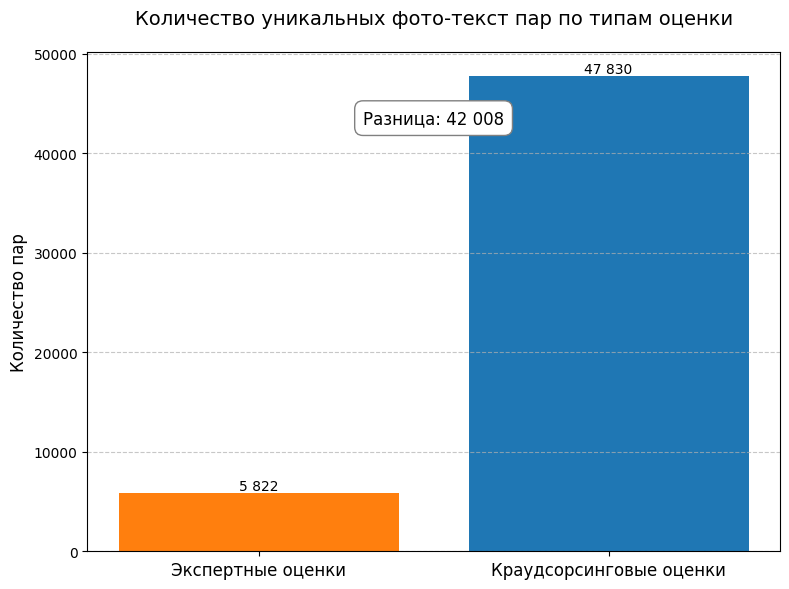

In [14]:
# Подготовка данных
categories = ['Экспертные оценки', 'Краудсорсинговые оценки']
values = [
    df_expert.drop_duplicates().shape[0],
    df_crowd.drop_duplicates().shape[0]
]
colors = ['#FF7F0E', '#1F77B4']  # Оранжевый и синий

# Создание графика
plt.figure(figsize=(8, 6))
bars = plt.bar(categories, values, color=colors)

# Добавление значений на столбцы
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}'.replace(',', ' '),
             ha='center', va='bottom', fontsize=10)

# Настройки графика
plt.title('Количество уникальных фото-текст пар по типам оценки', pad=20, fontsize=14)
plt.ylabel('Количество пар', fontsize=12)
plt.xticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Добавим разницу между столбцами
diff = abs(values[0] - values[1])
plt.annotate(f'Разница: {diff:,}'.replace(',', ' '),
             xy=(0.5, 0.9*max(values)), xycoords='data',
             ha='center', fontsize=12,
             bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray'))

plt.tight_layout()
plt.show()

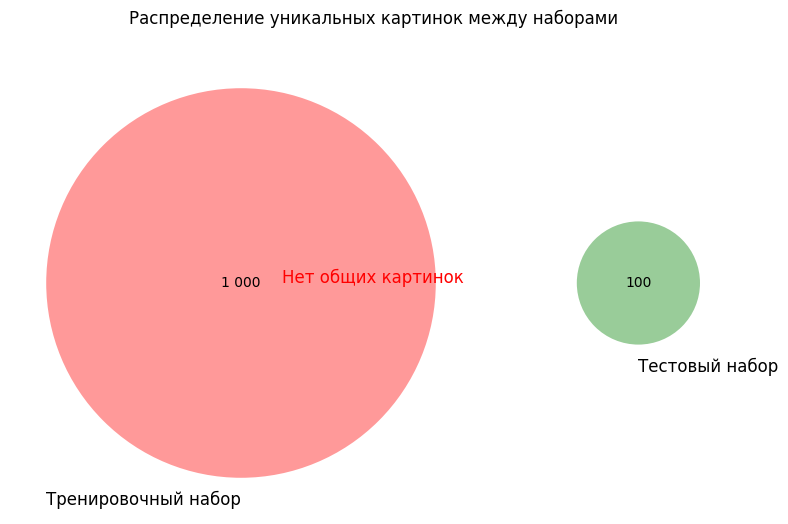

In [15]:

# Данные
train_set = set(df_train['image'])
test_set = set(df_test['image'])
intersection = train_set & test_set

# Создание диаграммы Венна
plt.figure(figsize=(10, 6))
venn = venn2([train_set, test_set], ('Тренировочный набор', 'Тестовый набор'))

# Устанавливаем подписи с проверкой на существование областей
if len(train_set - test_set) > 0:
    venn.get_label_by_id('10').set_text(f'{len(train_set - test_set):,}'.replace(',', ' '))
else:
    venn.get_label_by_id('10').set_text('0')

if len(test_set - train_set) > 0:
    venn.get_label_by_id('01').set_text(f'{len(test_set - train_set):,}'.replace(',', ' '))
else:
    venn.get_label_by_id('01').set_text('0')

if len(intersection) > 0:
    if venn.get_label_by_id('11') is not None:
        venn.get_label_by_id('11').set_text(f'{len(intersection):,}'.replace(',', ' '))
else:
    # Если нет пересечения, скрываем центральную область
    if venn.get_label_by_id('11') is not None:
        venn.get_label_by_id('11').set_text('0')
    plt.annotate('Нет общих картинок', 
                 xy=(0.5, 0.5), 
                 xycoords='axes fraction',
                 ha='center', 
                 fontsize=12,
                 color='red')

plt.title('Распределение уникальных картинок между наборами', pad=20)
plt.show()

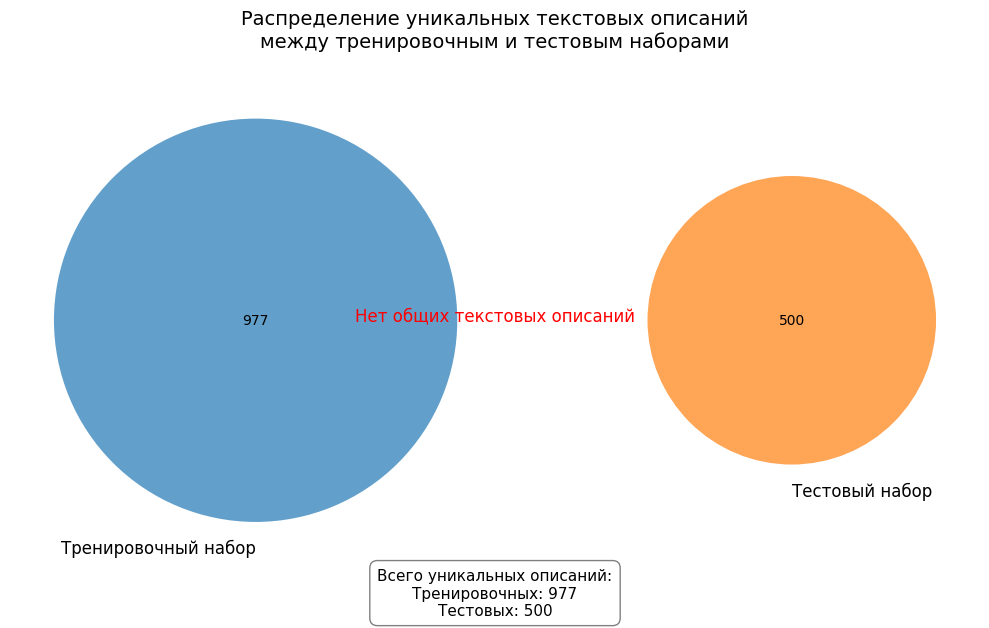

In [16]:
# Получаем данные
train_texts = set(df_train['query_text'])
test_texts = set(df_test['query_text'])
intersection = train_texts & test_texts

# Создаем фигуру
plt.figure(figsize=(10, 8))

# Рисуем диаграмму Венна
venn = venn2([train_texts, test_texts], 
             ('Тренировочный набор', 'Тестовый набор'),
             set_colors=('#1f77b4', '#ff7f0e'),
             alpha=0.7)

# Настраиваем подписи (с проверкой на существование областей)
if len(train_texts - test_texts) > 0:
    venn.get_label_by_id('10').set_text(f'{len(train_texts - test_texts):,}'.replace(',', ' '))
if len(test_texts - train_texts) > 0:
    venn.get_label_by_id('01').set_text(f'{len(test_texts - train_texts):,}'.replace(',', ' '))
if len(intersection) > 0:
    label = venn.get_label_by_id('11')
    if label is not None:  # Дополнительная проверка
        label.set_text(f'{len(intersection):,}'.replace(',', ' '))
else:
    # Если нет пересечения, добавляем соответствующую аннотацию
    plt.annotate('Нет общих текстовых описаний', 
                 xy=(0.5, 0.5), xycoords='axes fraction',
                 ha='center', fontsize=12, color='red')

# Добавляем заголовок и пояснения
plt.title('Распределение уникальных текстовых описаний\nмежду тренировочным и тестовым наборами', 
          pad=20, fontsize=14)
plt.annotate(f'Всего уникальных описаний:\n'
             f'Тренировочных: {len(train_texts):,}\n'
             f'Тестовых: {len(test_texts):,}',
             xy=(0.5, -0.1), xycoords='axes fraction',
             ha='center', fontsize=11,
             bbox=dict(boxstyle='round,pad=0.5', fc='white', ec='gray'))

plt.tight_layout()
plt.show()

 - Уникальных фото в тренировочной выборке: 1000, а в тестовой: 100
 - Экспертных оценок 5822, а оценок на краудсорсе 47830
 - Пересечений фотографий в тестовой и тренировочной выборке нет
 - Пересечений описаний  в тестовой и тренировочной выборке нет 

#### Вывод изображений на экран

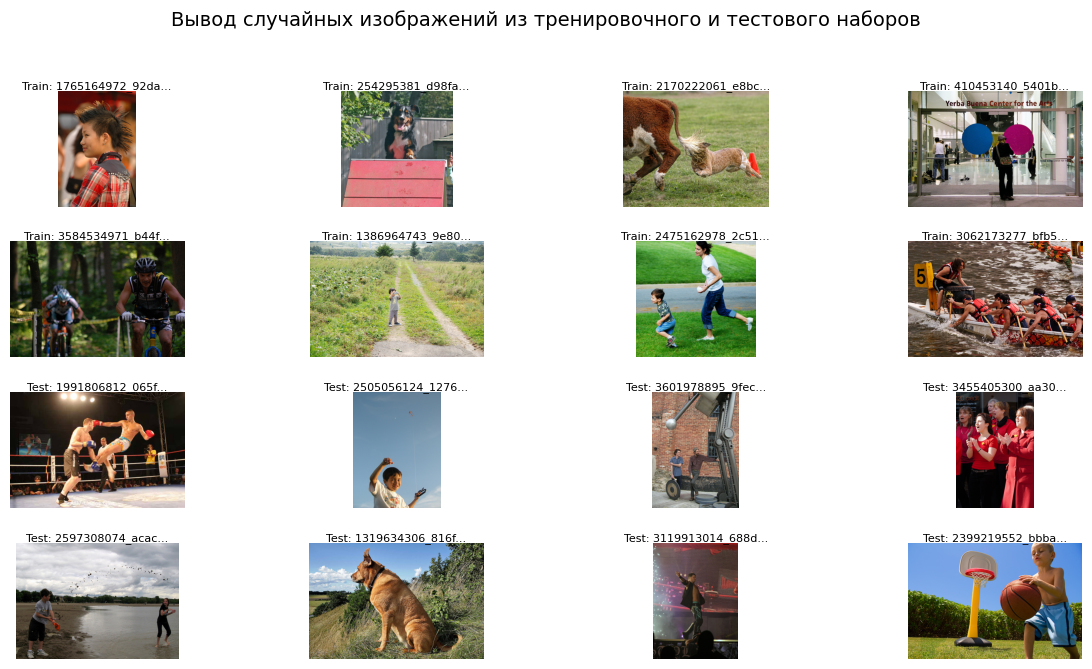

In [17]:
# Выведем по 8 случайных изображений из датасетов df_train и df_test

# Выбираем по 8 случайных изображений из каждого датасета
train_samples = sample(list(df_train['image']), min(8, len(df_train)))
test_samples = sample(list(df_test['image']), min(8, len(df_test)))

# Создаем фигуру с 4 строками и 4 колонками (всего 16 мест)
plt.figure(figsize=(12, 7))

# Выводим тренировочные изображения (первые 8 позиций)
for i, filename in enumerate(train_samples, 1):
    img_path = train_image_dir / filename
    ax = plt.subplot(4, 4, i)
    
    try:
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"Train: {filename[:15]}..." if len(filename) > 15 else f"Train: {filename}", 
                 fontsize=8, pad=2)
    except Exception as e:
        plt.imshow([[0,0,0]], cmap='gray')
        plt.title(f"Error: {str(e)[:15]}", fontsize=8, color='red', pad=2)
    
    plt.axis('off')

# Выводим тестовые изображения (позиции 9-16)
for i, filename in enumerate(test_samples, 9):
    img_path = test_image_dir / filename
    ax = plt.subplot(4, 4, i)
    
    try:
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"Test: {filename[:15]}..." if len(filename) > 15 else f"Test: {filename}", 
                 fontsize=8, pad=2)
    except Exception as e:
        plt.imshow([[0,0,0]], cmap='gray')
        plt.title(f"Error: {str(e)[:15]}", fontsize=8, color='red', pad=2)
    
    plt.axis('off')

# Добавляем общий заголовок и регулируем отступы
plt.suptitle('Вывод случайных изображений из тренировочного и тестового наборов', 
             fontsize=14, y=0.98)  

# Улучшаем расположение подграфиков
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Добавляем отступ сверху для заголовка
plt.subplots_adjust(hspace=0.3, wspace=0.1)  # Настраиваем расстояния между изображениями

plt.show()

Присутствуют изображения с детьми, которые необходимо отфильтровать, чтобы не противоречить юридическим нормам

#### Объединение данных с оценками экспертов и пользователей

In [18]:
df_expert.head()

image                     descr_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  mean_score  
0      1    1.000000  
1      2    1.333333  
2      2    1.333333  
3      2    1.666667  
4      2    1.333333

In [19]:
df_crowd.head()

image                     descr_id  ratio_confirmed  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2              1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2              0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2              0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2              0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2              0.0   

   num_confirmed  num_rejected  
0              3             0  
1              0             3  
2              0             3  
3              0             3  
4              0             3

In [20]:
df_expert.head()

image                     descr_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  mean_score  
0      1    1.000000  
1      2    1.333333  
2      2    1.333333  
3      2    1.666667  
4      2    1.333333

Создадим новый столбец с названием 'expert_score' где нормализуем оценки экспертов в диапазоне от 0 до 1, также будем учитвать консенсус экспертов, используя моду в случае когда эксперты назначили одинаковые оценки

In [21]:
def normalize_scores(row):
    scores = [row['first'], row['second'], row['third']]
    # Выбор моды, если есть совпадения
    if len(set(scores)) < 3:
        final_score = max(set(scores), key=scores.count)
    else:
        final_score = np.mean(scores)
    # Нормализация
    return (final_score - 1) / 3

df_expert['expert_score'] = df_expert.apply(normalize_scores, axis=1)

df_expert.head()

image                     descr_id  first  second  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1       1   

   third  mean_score  expert_score  
0      1    1.000000      0.000000  
1      2    1.333333      0.000000  
2      2    1.333333      0.000000  
3      2    1.666667      0.333333  
4      2    1.333333      0.000000

Объединим 2 датафрема df_expert и df_crowd. По принципу главенствующей оценки от экспертов. Там где есть оценка экспертов 'expert_score'  - используется она, там где нет оценки, используется оценка людей из колонки 'ratio_confirmed'  

In [22]:
df_expert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         5822 non-null   object 
 1   descr_id      5822 non-null   object 
 2   first         5822 non-null   int64  
 3   second        5822 non-null   int64  
 4   third         5822 non-null   int64  
 5   mean_score    5822 non-null   float64
 6   expert_score  5822 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 318.5+ KB


In [23]:
df_crowd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            47830 non-null  object 
 1   descr_id         47830 non-null  object 
 2   ratio_confirmed  47830 non-null  float64
 3   num_confirmed    47830 non-null  int64  
 4   num_rejected     47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [24]:
# Шаг 1: Объединяем все записи из обоих датафреймов (FULL OUTER JOIN)
df_merged = pd.merge(
    df_expert[['image', 'descr_id', 'expert_score']],
    df_crowd[['image', 'descr_id', 'ratio_confirmed']],
    on=['image', 'descr_id'],
    how='outer'  # Все записи из обоих датафреймов!
)

# Шаг 2: Создаем итоговую оценку (приоритет экспертов)
df_merged['final_score'] = df_merged['expert_score'].combine_first(df_merged['ratio_confirmed'])

# Шаг 3: Проверяем результат
print(f"Всего записей: {len(df_merged)}")
print(f"Из них экспертных: {df_merged['expert_score'].notna().sum()}")
print(f"Из них краудсорсинговых: {df_merged['ratio_confirmed'].notna().sum()}")

Всего записей: 51323
Из них экспертных: 5822
Из них краудсорсинговых: 47830


In [25]:
# Удалим столбцы expert_score и ratio_confirmed из df_merged
df_merged = df_merged.drop(['expert_score', 'ratio_confirmed'], axis=1)

In [26]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51323 non-null  object 
 1   descr_id     51323 non-null  object 
 2   final_score  51323 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.2+ MB


In [27]:
# Проверим df_merged на наличие пропусков и дубликатов
print('=== Проверка качества данных ===\n')

# Проверка дубликатов
print('Количество полных дубликатов строк:', df_merged.duplicated().sum())
print('Количество дубликатов по ключевым полям (image + descr_id):', 
      df_merged.duplicated(subset=['image', 'descr_id']).sum())
print()

# Проверка пропусков
print('Количество пропусков по столбцам:')
print(df_merged.isnull().sum())

=== Проверка качества данных ===

Количество полных дубликатов строк: 0
Количество дубликатов по ключевым полям (image + descr_id): 0

Количество пропусков по столбцам:
image          0
descr_id       0
final_score    0
dtype: int64


In [28]:
# Переименуем колонку descr_id в query_id для удобства объединения 
df_merged.rename(columns={'descr_id': 'query_id'}, inplace=True)

In [29]:
df_merged.head()

image                     query_id  final_score
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2          1.0
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2          0.0
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2          0.0
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2          0.0
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2          0.0

In [30]:
df_train.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [31]:
# Объединим df__train и df_merged
df_train = pd.merge(df_train, df_merged, on=['image', 'query_id'], how='outer')

df_train.head()

image                     query_id query_text  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2        NaN   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2        NaN   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2        NaN   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2        NaN   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2        NaN   

   final_score  
0          1.0  
1          0.0  
2          0.0  
3          0.0  
4          0.0

In [32]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51323 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        51323 non-null  object 
 1   query_id     51323 non-null  object 
 2   query_text   5822 non-null   object 
 3   final_score  51323 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.6+ MB


In [33]:
# Заполним пропуски в описаниях
# Создадим словарь {query_id: query_text} из непустых значений
text_mapping = df_train.dropna(subset=['query_text'])\
                       .drop_duplicates('query_id')\
                       .set_index('query_id')['query_text']\
                       .to_dict()



In [34]:
# Заполняем пропуски через map
df_train['query_text'] = df_train['query_text'].fillna(
    df_train['query_id'].map(text_mapping)
)

# Проверка результата
print(f"Осталось пропусков: {df_train['query_text'].isna().sum()}")

Осталось пропусков: 1109


In [35]:
# Оставшиеся пропуски удалим т.к. для них не нашлось описаний

df_train.dropna(inplace=True)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50214 entries, 0 to 51322
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        50214 non-null  object 
 1   query_id     50214 non-null  object 
 2   query_text   50214 non-null  object 
 3   final_score  50214 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.9+ MB


#### Выводы по разделу:

Выводы:
- Данные успешно загружены
- Пропуски не обнаружены
 в df_train: 
 - Уникальных фотографий 1000
 - Уникальных описаний 977
 - Самые популярные слова: dog, man, two, white, woman

Общие оценки экспертов и пользователей:
 - Распределение оценок экспертами в краудсорсе в большинстве совем говорит о том, что описание не соотвевует изображению, что может сказаться на качестве обучения
 
- Уникальных фото в тренировочной выборке: 1000, а в тестовой: 100
- Экспертных оценок 5822, а оценок на краудсорсе 47830
- Пересечений фотографий в тестовой и тренировочной выборке нет
- Пересечений описаний  в тестовой и тренировочной выборке нет 
 
Присутствуют изображения с детьми, которые необходимо отфильтровать, чтобы не противоречить юридическим нормам

 - Создали нормализованную единую систему оценок, чтобы можно было сравнивать оценки пользователей и экспертов
 - Объединили данные в единый датафрейм для дальнейшей работы, удалили пропуски
  

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [36]:
# Напишем функцию проверки на наличие запрещенных слов в тексте
def contains_blocked_content(text):
    """
    Проверяет текст на наличие запрещенных слов без лемматизации
    """
    if not isinstance(text, str):
        return False
        
    # Приводим к нижнему регистру и разбиваем на слова
    words = re.findall(r'\w+', text.lower())
    
    # Проверяем пересечение с запрещенными словами
    return any(word in STOP_WORDS for word in words)

# Применяем функцию и отмечаем блокируемые изображения
df_train['to_block'] = df_train['query_text'].apply(contains_blocked_content).astype(int)

# Получаем список ID блокируемых изображений
blocked_images = df_train[df_train['to_block'] == 1]['query_id'].str[:-2].str.lower().unique()
blocked_df = df_train[df_train['to_block'] == 1]

# Выводим первые 10 записей для проверки
print("Первые 10 блокируемых изображений:")
display(blocked_df[['image', 'query_id', 'query_text']].head(10))

# Создаем список уникальных ID блокируемых изображений
blocked_images = blocked_df['query_id'].str[:-2].str.lower().unique()

# Выводим статистику
print(f"\nВсего изображений, попадающих под блокировку: {len(blocked_images)}")
print(f"Всего записей с блокируемым контентом: {len(blocked_df)}")

# Дополнительная аналитика
print("\nТоп-10 самых частых запрещенных запросов:")
print(blocked_df['query_text'].value_counts().head(10))

Первые 10 блокируемых изображений:


image                     query_id  \
1   1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2   1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
10  1056338697_4f7d7ce270.jpg  2436081047_bca044c1d3.jpg#2   
11  1056338697_4f7d7ce270.jpg  2490768374_45d94fc658.jpg#2   
12  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
13  1056338697_4f7d7ce270.jpg  2588927489_f4da2f11ec.jpg#2   
14  1056338697_4f7d7ce270.jpg  2594042571_2e4666507e.jpg#2   
18  1056338697_4f7d7ce270.jpg  2666205903_8d287669e1.jpg#2   
19  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
28  1056338697_4f7d7ce270.jpg  3143155555_32b6d24f34.jpg#2   

                                           query_text  
1           A boy in glasses is wearing a red shirt .  
2    A young boy holds onto a blue handle on a pier .  
10  A little girl wearing a pink shirt jumps off a...  
11                 a young girl wearing blue smiles .  
12  A young child is wearing blue goggles and sitt...  
13  A young boy wearing a blue and red hat is usin...  
14  A smiling boy in an orange shirt with a safari...  
18  A girls in a blue shirt holds a flower while s...  
19  A girl wearing a yellow shirt and sunglasses s...  
28  Two babies are sitting close together while re...


Всего изображений, попадающих под блокировку: 300
Всего записей с блокируемым контентом: 14740

Топ-10 самых частых запрещенных запросов:
query_text
Two children look up .                                                          152
Two girls walking down the street .                                             127
A man in an ampitheater talking to a boy .                                      116
Two girls with orange shirts .                                                  115
The boy is whispering in the girls ear .                                        112
two girls dress up for halloween .                                              107
A girl is wear a green dress .                                                  107
A young boy jumping in front of a young girl and a house .                      104
A girls in a blue shirt holds a flower while sitting on a man 's shoulders .    104
A young boy is holding a book .                                                 103
Name: coun

#### Удалим запрещенные изображения

In [37]:
# Создаем копию DataFrame без заблокированных изображений
df_train_clean = df_train[df_train['to_block'] == 0].copy()

# Проверяем результат
print(f"Исходное количество изображений: {len(df_train)}")
print(f"Количество после очистки: {len(df_train_clean)}")
print(f"Удалено изображений: {len(df_train) - len(df_train_clean)}")

# Сохраняем список удаленных изображений (опционально)
blocked_images_list = blocked_df['image'].unique()
print("\nПримеры удаленных изображений:")
print(blocked_images_list[:10])  # Первые 10 удаленных изображений

# Если нужно перезаписать исходный DataFrame (раскомментируйте)
# df_train = df_train_clean

Исходное количество изображений: 50214
Количество после очистки: 35474
Удалено изображений: 14740

Примеры удаленных изображений:
['1056338697_4f7d7ce270.jpg' '106490881_5a2dd9b7bd.jpg'
 '1082379191_ec1e53f996.jpg' '1084040636_97d9633581.jpg'
 '1096395242_fc69f0ae5a.jpg' '1107246521_d16a476380.jpg'
 '1119015538_e8e796281e.jpg' '1122944218_8eb3607403.jpg'
 '1131800850_89c7ffd477.jpg' '1131932671_c8d17751b3.jpg']


In [38]:
df_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35474 entries, 0 to 51322
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        35474 non-null  object 
 1   query_id     35474 non-null  object 
 2   query_text   35474 non-null  object 
 3   final_score  35474 non-null  float64
 4   to_block     35474 non-null  int32  
dtypes: float64(1), int32(1), object(3)
memory usage: 1.5+ MB


Выводы:
 - Создан список, содержащий связаннйе с детьми слова
 - Удалены изображение, описания которых попали под блокировку


## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [39]:
# Посмотрим кол-во уникальных изображений в тренировочном наборе
print('Тренировочный набор: ', len(df_train_clean['image'].unique()))

Тренировочный набор:  1000


In [40]:
def vectorize_images(path=PATH, train=True):
    """Загрузка уникальных данных для обучения"""
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Получаем уникальные пути к изображениям
    unique_images = df_train_clean['image'].unique()
    unique_df = pd.DataFrame({'image': unique_images})

    # Создаем генератор на основе уникальных изображений
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=unique_df,
        directory=str(train_image_dir),  # Преобразуем Path в строку
        x_col='image',
        y_col=None,  # y_col оставляем пустым, если не нужны метки
        target_size=(224, 224),
        batch_size=32,
        class_mode=None,
        shuffle=False,
        seed=RANDOM_STATE
    )
    return train_gen_flow

def vectorize(model, train_data):
    """Векторизация изображений"""
    return model.predict(train_data, verbose=1)



In [41]:
def create_model(input_shape=(224, 224, 3)):


    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mean_squared_error'])

    return model

def vectorize(model, train_data):
    """Векторизация изображений"""
    return model.predict(train_data, verbose=1)

In [42]:
# Обновляем векторизацию, используя только уникальные изображения
train_data = vectorize_images()
vectorized_images = vectorize(create_model(), train_data)
print(vectorized_images.shape) 

Found 1000 validated image filenames.
32/32 ━━━━━━━━━━━━━━━━━━━━ 26s 774ms/step
(1000, 2048)


У нас 1000 уникальный изображений, поэтому мы можем векторизировать только их для обучения модели.

Векторизация изображений выполнена

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


Для векторизации тектов применим трансформер BERT base cased

In [43]:
df_train_clean['query_text'].shape

(35474,)

In [44]:
# Получаем уникальные тексты
unique_texts = df_train_clean['query_text'].unique()
print(f"Уникальных текстов: {len(unique_texts)}")

Уникальных текстов: 677


In [45]:
# Шаг 1: Загружаем предобученный токенизатор и модель BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = BertModel.from_pretrained('bert-base-cased')

In [46]:
# Токенизация
tokenized = [tokenizer.encode(text, add_special_tokens=True, max_length=512, truncation=True)
             for text in unique_texts]

# Padding
max_len = max(len(t) for t in tokenized)
padded = np.array([t + [0] * (max_len - len(t)) for t in tokenized])

# Attention mask
attention_mask = np.where(padded != 0, 1, 0)

In [47]:
# Векторизация
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)

embeddings = []
total_batches = (len(padded) + batch_size - 1) // batch_size

for i in range(total_batches):
    start = i * batch_size
    end = min(start + batch_size, len(padded))

    batch_input = torch.LongTensor(padded[start:end]).to(device)
    batch_mask = torch.LongTensor(attention_mask[start:end]).to(device)

    with torch.no_grad():
        outputs = bert_model(batch_input, attention_mask=batch_mask)
        embeddings.append(outputs.last_hidden_state[:, 0, :].cpu().numpy())

# Получаем массив (n_unique_texts, 768)
unique_text_vectors = np.concatenate(embeddings, axis=0)
print("Векторизация уникальных текстов:", unique_text_vectors.shape)

Векторизация уникальных текстов: (677, 768)


Векторизация уникальных текстов также выполнена успешно

## 5. Объединение векторов

#### Объединим векторы изображений и векторы текстов с целевой переменной.

In [48]:
# Проверяем размеры
num_images = vectorized_images.shape[0]
num_texts = unique_text_vectors.shape[0]

# Правильный вывод размеров
print(f"Размер векторов изображений: {num_images}")
print(f"Размер векторов текстов: {num_texts}")

Размер векторов изображений: 1000
Размер векторов текстов: 677


In [49]:
# Создаем словарь {имя_изображения: вектор}
image_to_vector = dict(zip(df_train_clean['image'].unique(), vectorized_images))

# Для каждой строки в df_train_clean получаем соответствующий вектор изображения
repeated_image_vectors = np.array([image_to_vector[img] for img in df_train_clean['image']])
print("Повторённые вектора картинок:", repeated_image_vectors.shape)



Повторённые вектора картинок: (35474, 2048)


In [50]:
text_to_vector = dict(zip(unique_texts, unique_text_vectors))

# Повторение векторов по основному датафрейму
repeated_text_vectors = np.array([text_to_vector[text] for text in df_train_clean['query_text']])
print("Повторённые текстовые вектора:", repeated_text_vectors.shape)

Повторённые текстовые вектора: (35474, 768)


In [51]:
# Теперь объединяем
X = np.concatenate((repeated_image_vectors, repeated_text_vectors), axis=1)
print("Фичи", X.shape) 

y = np.array(df_train_clean['final_score'])
print("Таргет", y.shape)

Фичи (35474, 2816)
Таргет (35474,)


Векторы успешно объеденены, таргет и признаки разделены.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Будем использовать несколько моделей и выберем лучшую из них.

In [52]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=df_train_clean['image']))

In [53]:
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [54]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)



Выберем метрику RMSE для оценки качества модели. Потому что данная метрика показывает насколько сильно модель отклоняется от реальных данных и удобна к пониманию т.к. она имеет размерность, которая соответствует размерности исходных данных.

In [55]:
# 1. Создаем и обучаем dummy-модель
print("\n" + "="*50)
print("Dummy Regression")
print("="*50)


dummy_model = DummyRegressor(strategy='mean') 
dummy_model.fit(X_train, y_train)

# Предсказания на тестовых данных
dummy_preds = dummy_model.predict(X_test)

# Оценка качества
dummy_mse = mean_squared_error(y_test, dummy_preds)
dummy_mae = mean_absolute_error(y_test, dummy_preds)
dummy_r2 = r2_score(y_test, dummy_preds)

print(f"MSE: {dummy_mse:.4f}")
print(f"MAE: {dummy_mae:.4f}")
print(f"R²: {dummy_r2:.4f}")


Dummy Regression
MSE: 0.0494
MAE: 0.1480
R²: -0.0004


In [56]:
# 2. Создаем и обучаем линейную регрессию
print("\n" + "="*50)
print("Linear Regression")
print("="*50)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Предсказания на тестовых данных
lr_preds = lr_model.predict(X_test)

# Вычисляем метрики
lr_mse = mean_squared_error(y_test, lr_preds)
lr_mae = mean_absolute_error(y_test, lr_preds)
lr_r2 = r2_score(y_test, lr_preds)

# Выводим результаты
print(f"MSE: {lr_mse:.4f}")
print(f"MAE: {lr_mae:.4f}")
print(f"R²: {lr_r2:.4f}")


Linear Regression
MSE: 0.0486
MAE: 0.1397
R²: 0.0173


In [57]:
# 3. Decision Tree
print("\n" + "="*50)
print("Decision Tree Regression")
print("="*50)
dt_model = DecisionTreeRegressor(random_state=RANDOM_STATE)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)

dt_mse = mean_squared_error(y_test, dt_preds)
dt_mae = mean_absolute_error(y_test, dt_preds)
dt_r2 = r2_score(y_test, dt_preds)

print(f"MSE: {dt_mse:.4f}")
print(f"MAE: {dt_mae:.4f}")
print(f"R²: {dt_r2:.4f}")


Decision Tree Regression
MSE: 0.0918
MAE: 0.1430
R²: -0.8574


In [ ]:
# 4. CatBoost
print("\n" + "="*50)
print("CatBoost Regression")
print("="*50)
cb_model = CatBoostRegressor(iterations=1000,
                            learning_rate=0.1,
                            depth=6,
                            random_seed=RANDOM_STATE,
                            verbose=0)
cb_model.fit(X_train, y_train)
cb_preds = cb_model.predict(X_test)

cb_mse = mean_squared_error(y_test, cb_preds)
cb_mae = mean_absolute_error(y_test, cb_preds)
cb_r2 = r2_score(y_test, cb_preds)

print(f"MSE: {cb_mse:.4f}")
print(f"MAE: {cb_mae:.4f}")
print(f"R²: {cb_r2:.4f}")


CatBoost Regression


In [ ]:
# 5. LightGBM
print("\n" + "="*50)
print("LightGBM Regression")
print("="*50)
lgbm_model = LGBMRegressor(n_estimators=1000,
                          learning_rate=0.05,
                          max_depth=5,
                          random_state=RANDOM_STATE)
lgbm_model.fit(X_train, y_train)
lgbm_preds = lgbm_model.predict(X_test)

lgbm_mse = mean_squared_error(y_test, lgbm_preds)
lgbm_mae = mean_absolute_error(y_test, lgbm_preds)
lgbm_r2 = r2_score(y_test, lgbm_preds)

print(f"MSE: {lgbm_mse:.4f}")
print(f"MAE: {lgbm_mae:.4f}")
print(f"R²: {lgbm_r2:.4f}")


LightGBM Regression


  File "c:\Users\zurik\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\zurik\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\zurik\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\zurik\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.456560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 713603
[LightGBM] [Info] Number of data points in the train set: 24677, number of used features: 2816
[LightGBM] [Info] Start training from score 0.091168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [ ]:
# 6. Нейронная сеть
print("\n" + "="*50)
print("Neural Network Regression")
print("="*50)

# Нормализация данных
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создание модели
nn_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)  # Выходной слой для регрессии
])

# Компиляция
nn_model.compile(optimizer=Adam(learning_rate=0.001),
                loss='mse',
                metrics=['mae'])

# Обучение
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = nn_model.fit(X_train_scaled, y_train,
                      validation_split=0.2,
                      epochs=100,
                      batch_size=32,
                      callbacks=[early_stop],
                      verbose=1)

# Предсказания
nn_preds = nn_model.predict(X_test_scaled).flatten()

# Оценка
nn_mse = mean_squared_error(y_test, nn_preds)
nn_mae = mean_absolute_error(y_test, nn_preds)
nn_r2 = r2_score(y_test, nn_preds)

print(f"MSE: {nn_mse:.4f}")
print(f"MAE: {nn_mae:.4f}")
print(f"R²: {nn_r2:.4f}")




Neural Network Regression
Epoch 1/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1838 - mae: 0.2890 - val_loss: 0.0508 - val_mae: 0.1237
Epoch 2/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0513 - mae: 0.1466 - val_loss: 0.0490 - val_mae: 0.1163
Epoch 3/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0474 - mae: 0.1371 - val_loss: 0.0476 - val_mae: 0.1240
Epoch 4/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0478 - mae: 0.1381 - val_loss: 0.0471 - val_mae: 0.1197
Epoch 5/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0438 - mae: 0.1290 - val_loss: 0.0455 - val_mae: 0.1243
Epoch 6/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0431 - mae: 0.1274 - val_loss: 0.0458 - val_mae: 0.1164
Epoch 7/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0448 - mae: 0.1291 - val_loss: 0.0453 - val_mae: 0.1192
Epoch 8/100
617/617 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0422 - mae: 0.1248 - val_loss: 0.0446 - val_mae: 0.1176
Epoch 9/100
617/617 ━

In [ ]:
# Добавляем вычисление RMSE для всех моделей
dummy_rmse = sqrt(dummy_mse)
lr_rmse = sqrt(lr_mse)
dt_rmse = sqrt(dt_mse)
cb_rmse = sqrt(cb_mse)
lgbm_rmse = sqrt(lgbm_mse)
nn_rmse = sqrt(nn_mse)

# Сравнение всех моделей с RMSE
results = pd.DataFrame({
    'Model': ['DummyRegressor', 'Linear Regression', 'Decision Tree', 'CatBoost', 'LightGBM', 'Neural Network'],
    'RMSE': [dummy_rmse, lr_rmse, dt_rmse, cb_rmse, lgbm_rmse, nn_rmse],
    'MSE': [dummy_mse, lr_mse, dt_mse, cb_mse, lgbm_mse, nn_mse],
    'MAE': [dummy_mae, lr_mae, dt_mae, cb_mae, lgbm_mae, nn_mae],
    'R²': [dummy_r2, lr_r2, dt_r2, cb_r2, lgbm_r2, nn_r2]
})

# Форматируем вывод для лучшей читаемости
pd.options.display.float_format = '{:.4f}'.format

print("\n" + "="*70)
print("Сравнение всех моделей (отсортировано по RMSE):")
print("="*70)
print(results.sort_values(by='RMSE').reset_index(drop=True))

# Дополнительная визуализация
print("\nЛучшая модель:")
print("-"*70)
print(f"Лучшая RMSE: {results.loc[results['RMSE'].idxmin(), 'Model']} ({results['RMSE'].min():.4f})")



Сравнение всех моделей (отсортировано по RMSE):
               Model   RMSE    MSE    MAE      R²
0           LightGBM 0.2053 0.0421 0.1218  0.1473
1           CatBoost 0.2055 0.0422 0.1225  0.1458
2     Neural Network 0.2070 0.0428 0.1173  0.1334
3  Linear Regression 0.2204 0.0486 0.1397  0.0173
4     DummyRegressor 0.2224 0.0494 0.1480 -0.0004
5      Decision Tree 0.3076 0.0946 0.1457 -0.9140

Лучшая модель:
----------------------------------------------------------------------
Лучшая RMSE: LightGBM (0.2053)


Лучший результат показала модель LightGBM, её RMSE составил 0.2053. Данную модель быдем использовать на тестовой выборке.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получим эмбеддинги для тестовых изображений из папки `test_images`, выберем случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведем наиболее релевантное изображение

In [ ]:
def vectorize_test_images(test_df, test_image_dir, target_size=(224, 224), batch_size=32):
    """Векторизация тестовых изображений"""
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=str(test_image_dir),
        x_col='image',
        y_col=None,  # Нет меток у тестовых данных
        target_size=target_size,
        batch_size=batch_size,
        class_mode=None,
        shuffle=False
    )

    return test_gen_flow


In [ ]:
print('Уникальные  фото набор: ', len(df_test['image'].unique()))

Уникальные  фото набор:  100


In [ ]:
# Получаем уникальные изображения из теста
unique_test_images = df_test['image'].unique()
test_unique_df = pd.DataFrame({'image': unique_test_images})

# Векторизация
test_data_flow = vectorize_test_images(test_unique_df, test_image_dir)
test_vectors = vectorize(create_model(), test_data_flow)
print("Размерность векторов тестовых изображений:", test_vectors.shape)

# Создаем отображение: имя → вектор
test_image_to_vector = dict(zip(unique_test_images, test_vectors))

Found 100 validated image filenames.
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step  
Размерность векторов тестовых изображений: (100, 2048)


In [ ]:
random_queries = df_test.sample(10)["query_text"]

# Напишем функцию, которая будет проверять, содержит ли текст стоп-слова.
def contains_stop_words(text, stop_words):
    text_lower = text.lower()
    return any(stop_word in text_lower for stop_word in stop_words)


results = []
for query_text in random_queries:
    if contains_stop_words(query_text, STOP_WORDS):
        results.append({
            "query_text": query_text,
            "best_image": None,
            "best_score": None
        })
        continue

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert_model.to(device)

    encoded = tokenizer.encode_plus(
        query_text,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

    input_ids = encoded['input_ids'].to(device)
    attention_mask = encoded['attention_mask'].to(device)

    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
        text_vector = outputs.last_hidden_state[:, 0, :].cpu().numpy()

    image_names = []
    predictions = []

    for img_name, img_vector in test_image_to_vector.items():
        combined = np.concatenate((img_vector, text_vector.squeeze()))
        combined = scaler.transform(combined.reshape(1, -1))
        pred = lgbm_model.predict(combined)
        image_names.append(img_name)
        predictions.append(pred[0])

    best_idx = np.argmax(predictions)
    best_image = image_names[best_idx]
    best_score = predictions[best_idx]

    results.append({
        "query_text": query_text,
        "best_image": best_image,
        "best_score": best_score
    })

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results)

In [ ]:
# Функция для отображения результатов

def display_query_results(results_df, test_image_dir, tokenizer, bert_model, test_image_to_vector, scaler, lgbm_model, n_to_show, max_length=512):
    """
    Параметры:
    - results_df: DataFrame с результатами запросов
    - test_image_dir: директория с тестовыми изображениями
    - tokenizer, bert_model, test_image_to_vector, scaler, lgbm_model: модели для пересчёта score
    - n_to_show: количество результатов для отображения
    - max_length: максимальная длина текста для BERT
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bert_model.to(device)
    
    for i, row in results_df.head(n_to_show).iterrows():
        plt.figure(figsize=(12, 4))
        
        # Текстовый запрос
        plt.subplot(1, 2, 1)
        plt.text(0.1, 0.5, f"Запрос:\n{row['query_text']}", 
                fontsize=10, ha='left', va='center')
        plt.axis('off')
        
        # Изображение или сообщение
        plt.subplot(1, 2, 2)
        if row['best_image'] is None:
            plt.text(0.5, 0.5, "This image is unavailable in your country\nin compliance with local laws", 
                    ha='center', va='center', fontsize=10, color='red')
            plt.axis('off')
        else:
            try:
                img_path = str(test_image_dir / row['best_image'])
                img = mpimg.imread(img_path)
                
                # Пересчитываем score для отображения
                query_text = row['query_text']
                encoded = tokenizer.encode_plus(
                    query_text,
                    add_special_tokens=True,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                input_ids = encoded['input_ids'].to(device)
                attention_mask = encoded['attention_mask'].to(device)
                
                with torch.no_grad():
                    outputs = bert_model(input_ids, attention_mask=attention_mask)
                    text_vector = outputs.last_hidden_state[:, 0, :].cpu().numpy()
                
                img_vector = test_image_to_vector[row['best_image']]
                combined = np.concatenate((img_vector, text_vector.squeeze()))
                combined = scaler.transform(combined.reshape(1, -1))
                score = lgbm_model.predict(combined)[0]
                
                plt.imshow(img)
                plt.title(f"Best Image\nScore: {score:.4f}", pad=20)
                plt.axis('off')
            except FileNotFoundError:
                plt.text(0.5, 0.5, "Изображение не найдено", 
                        ha='center', va='center')
                plt.axis('off')
        
        plt.tight_layout()
        plt.show()




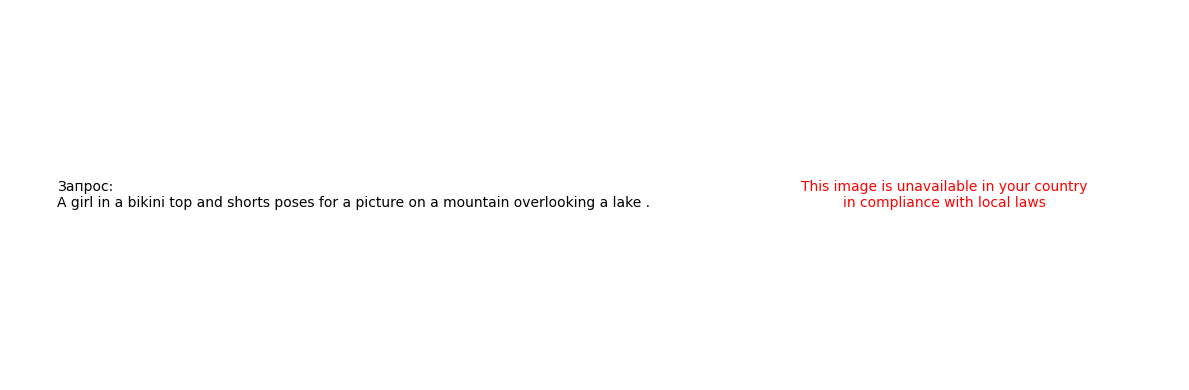

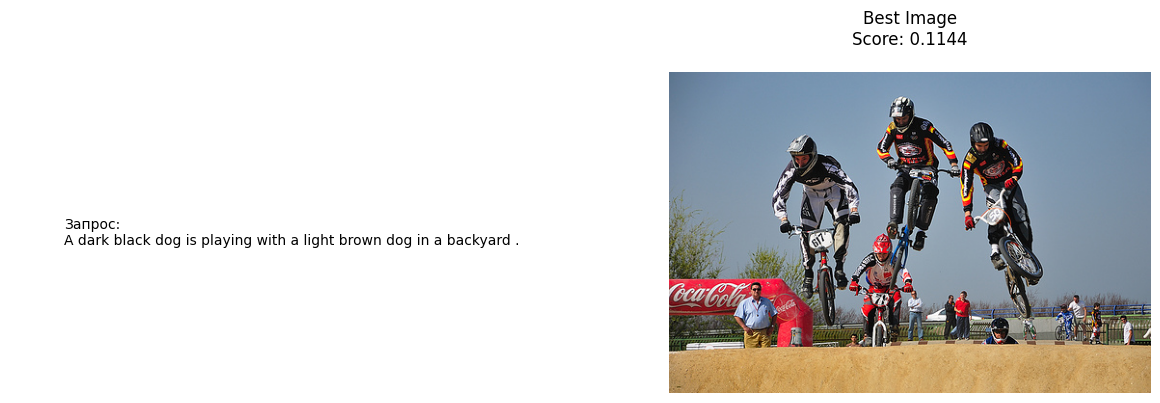

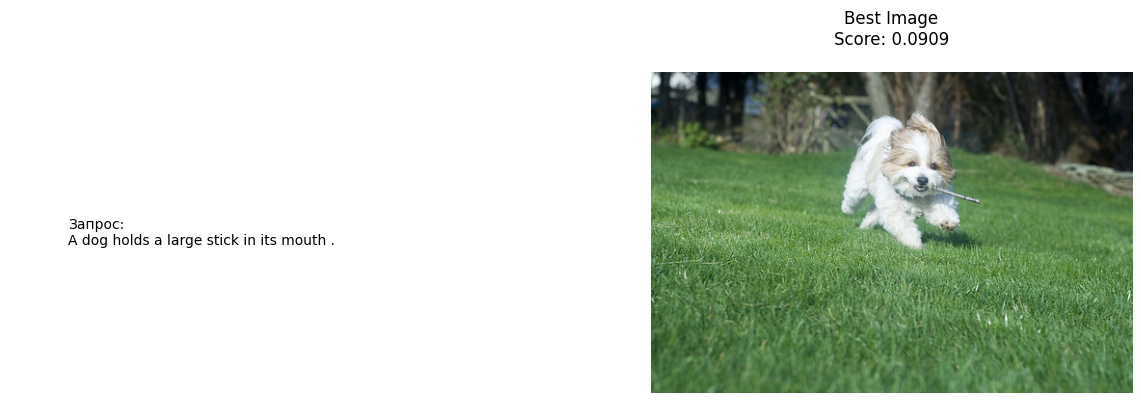

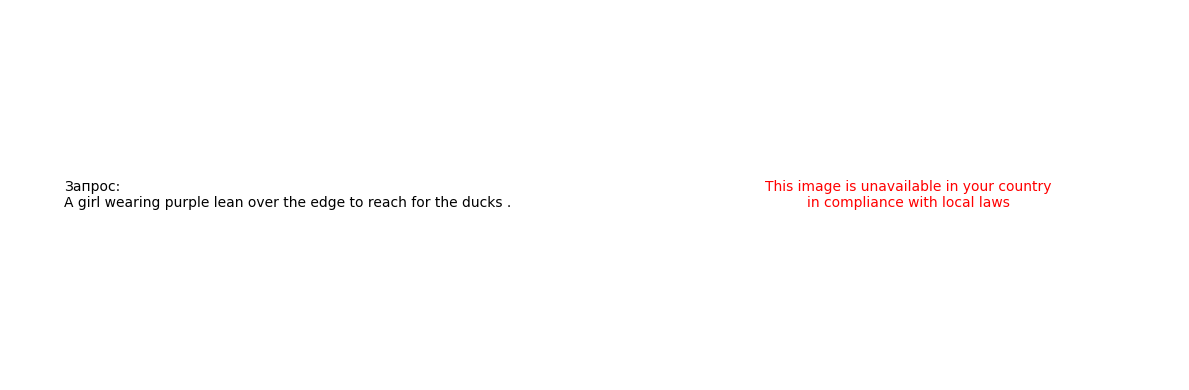

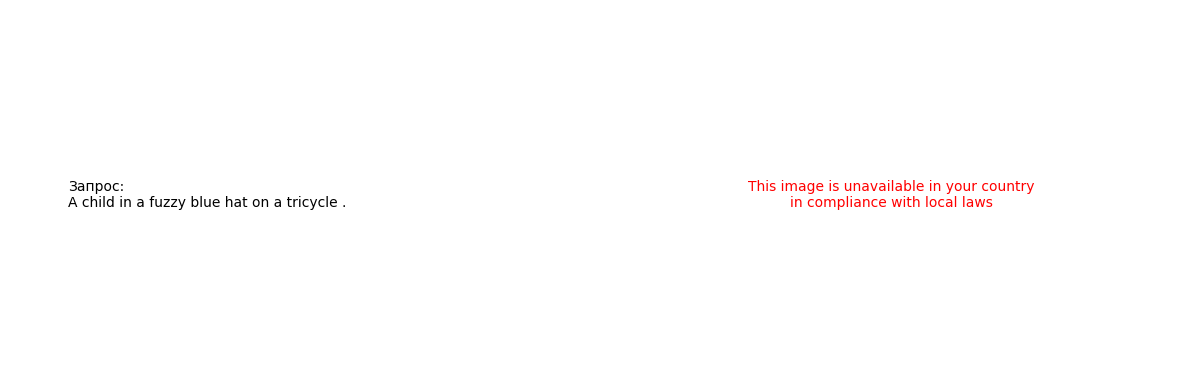

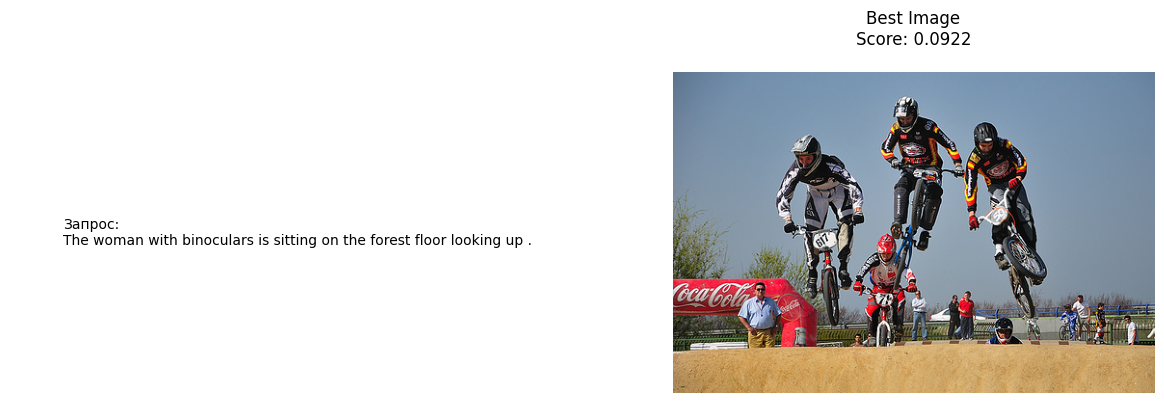

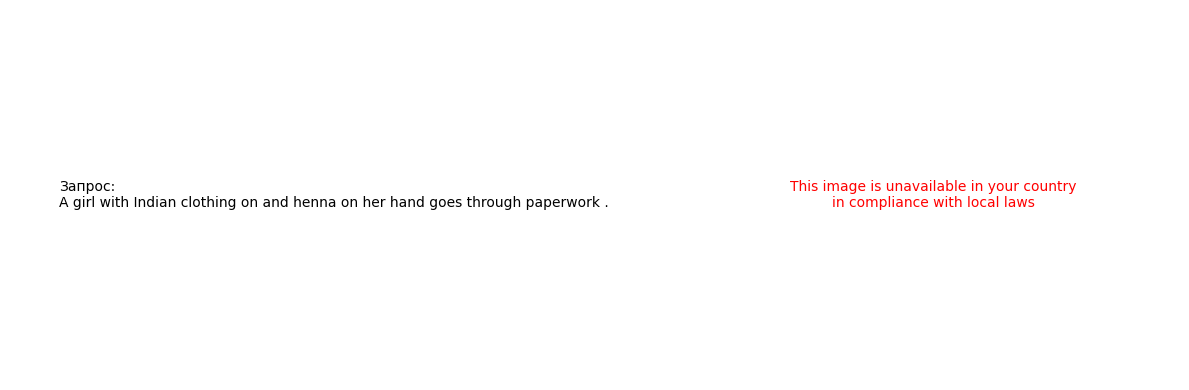

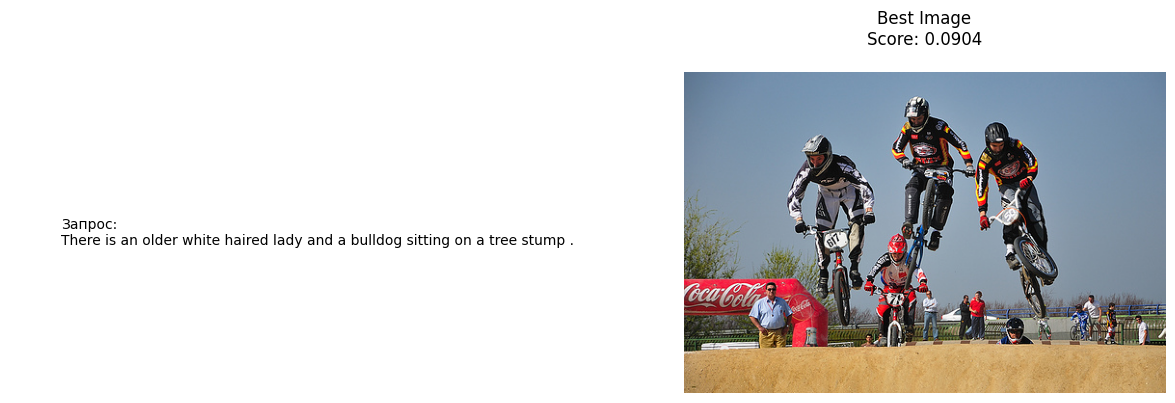

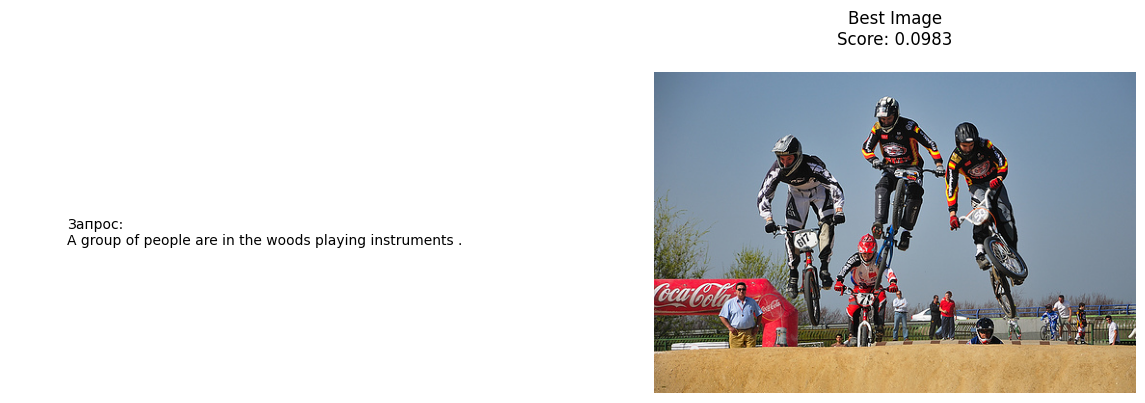

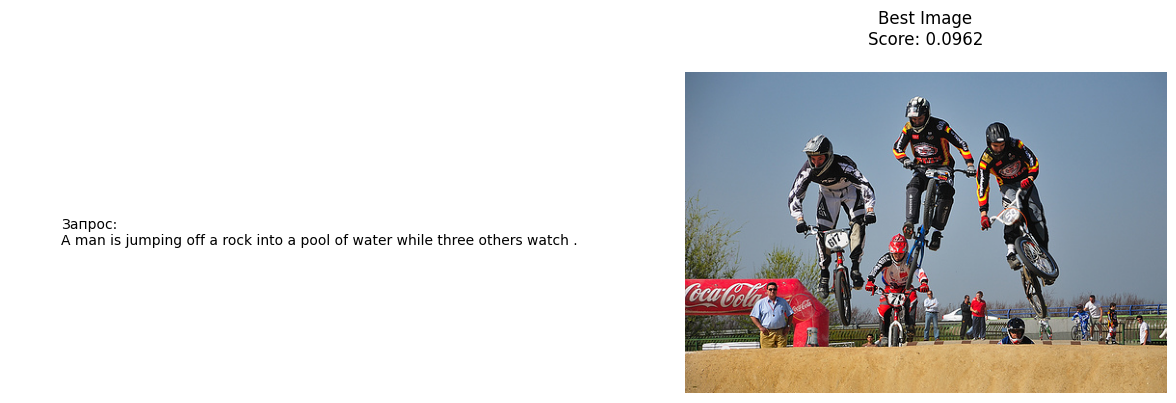

In [ ]:
# Применим функцию
display_query_results(
    results_df, 
    test_image_dir, 
    tokenizer,
    bert_model,
    test_image_to_vector,
    scaler,
    lgbm_model,
    n_to_show=10)

Как вы видим, модель плохо справляется с предсказанием, в большинстве своем не угадывает Возможно это связано С малой базой для обучения, плюс качество описаний в большентсве своем не соотвествет фотографии

## 8. Выводы
В рамках проекта стояла задача разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе покажет, насколько текст и картинка подходят друг другу.

- В ходе проекта были изучены и обработаны данные
- Выполнена векторизация изображений с помощью ResNet50
- Выполнена векторизация текстов с помощью BERT base cased EN
- Обучены 5 моделей для оценки схожести текста и изображения: LinearRegression, DecisionTreeRegressor, Catboost, LightGBM, нейронная сеть
- Лучший результат показала LightGBM с метрикой RMSE = 0.2053. На ней и проводилось тестирование.
- В рамках тестирования создана функция, возвращающая 10 наиболее подходящих под описание фотографий. 

К сожалению, результат работы такой модели оказался не очень ховорим, она часото ошибается, лишь иногда показывает соотвевствие текста и изображения.
Рекомендуется увеличить базу данных для обучения на большее количество изображений, а также добавить большее количество текстовых описаний.






- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска